Trabajo ejemplo tomado del curso de Inteligencia Artificial IA2023II. El ejemplo está construido con un conjunto de datos disponible en Kaggle: https://www.kaggle.com/datasets/fedesoriano/gisette-dataset-mnist-digits-4-and-9/data

# Gisette Dataset (MNIST digits 4 and 9)
En el actual notebook se encuentra el código necesario para realizar los diferentes métodos de Machine Learning:
* Arbol de decisión
* Random Forest
* Redes Neuronales
* Redes Neuronales Profundas

## Descipción del problema
El problema de **GISETTE** es un problema de reconocimiento de dígitos escritos a mano. Es un problema de clasificación el cual consiste en separar los dígitos '4' y '9', que son altamente confusos.

Los dígitos y datos originales fueron preprocesados, ya que las imágenes de los dígitos fueron todas normalizadas a un tamaño de 28x28 pixeles. Los siguientes son ejemplos de las imágenes

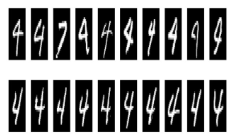

Sin embargo, solamente se usaron ciertos píxeles de la parte superior central de la imagen (muestreados al azar) para crear este dataset y por último se crearon nuevas características multiplicando los valores de algunos pixeles para aumentar la dimensionalidad.

El reto que nos propone el dataset es construir un algoritmo de aprendizaje automático que sea capaz de seleccionar las características apropiadas, ya que el conjunto de datos incluye un total de 5000 características de las cuales 2500 no tienen poder predictivo.

## Contenido del dataset
Para poder realizar una visualización de los datos necesitaremos las siguientes librerías:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn import tree, ensemble, neural_network
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Como los datos se encuentran en el archivo gisette.pickle, tenemos que exportar los datos

In [2]:
gisette_data = pd.read_pickle(r'gisette.pickle')
gisette_data

{'training': {'data': array([[550.,   0., 495., ...,   0.,   0., 983.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0., 991., ...,   0.,   0., 991.]]),
  'labels': array([ 1., -1.,  1., ..., -1., -1., -1.])},
 'validation': {'data': array([[688.,   0.,   0., ...,   0., 769.,   0.],
         [778., 758.,   0., ...,   0.,   0.,   0.],
         [469.,   0., 816., ..., 417.,   0.,   0.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0., 742.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]]),
  'labels': array([ 1.,  1., -1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,  1., -1.,
          1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,
          1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,
         -1.,

In [3]:
type(gisette_data)

dict

In [4]:
gisette_data.keys()

dict_keys(['training', 'validation', 'testing'])

In [5]:
print('Training keys: ',gisette_data['training'].keys())
print('Validation keys: ',gisette_data['validation'].keys())
print('Testing keys: ',gisette_data['testing'].keys())

Training keys:  dict_keys(['data', 'labels'])
Validation keys:  dict_keys(['data', 'labels'])
Testing keys:  dict_keys(['data'])


Como se puede observar, este dataset nos devuelve un diccionario, el cual contiene 3 claves: **training**, **validation** y **testing**. Cada una de estas claves tiene su valor, en la que cada valor son los datos o características representados como **data** y la variable a predecir llamada **labels** a excepción de **testing** que simplemente tiene los datos y no la variable a predecir.

En este caso la variable a predecir o **labels** representan si es un 4 o un 9, por lo cual si *label=-1* representa al dígito 9 y si *label=1* representa al dígito 4.

In [6]:
print('Examples of training data:',len(gisette_data['training']['data']))
print('Examples of validation data:',len(gisette_data['validation']['data']))
print('Examples of testing data:',len(gisette_data['testing']['data']))

Examples of training data: 6000
Examples of validation data: 1000
Examples of testing data: 6500


Se observa igualmente que los datos que nos proporciona el dataset para entrenar, validar y testear el modelo tienen diferentes ejemplos o filas. Sin embargo, para testear el modelo, utilizaremos los datos que nos proporciona *validation* ya que los datos de *testing* no tienen una variable a predecir, y nuestra intención es realizar un aprendizaje supervisado.

## Análisis de los datos
Para poder analizar los datos, utilizaremos el conjunto de datos de **training** y lo convertiremos a un objeto de tipo DataFrame. Luego se muestra información importante sobre los datos

In [7]:
training_data = gisette_data['training']['data']
training_labels = gisette_data['training']['labels']
# Convertir los datos en un objeto de tipo DataFrame de la libreria Pandas
X = pd.DataFrame(data=training_data, columns=['feature_'+str(i) for i in range(len(training_data[0]))])
X['labels'] = training_labels
# Se muestra la información de los datos
X.info(verbose=True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 5001 columns):
 #     Column        Non-Null Count  Dtype  
---    ------        --------------  -----  
 0     feature_0     6000 non-null   float64
 1     feature_1     6000 non-null   float64
 2     feature_2     6000 non-null   float64
 3     feature_3     6000 non-null   float64
 4     feature_4     6000 non-null   float64
 5     feature_5     6000 non-null   float64
 6     feature_6     6000 non-null   float64
 7     feature_7     6000 non-null   float64
 8     feature_8     6000 non-null   float64
 9     feature_9     6000 non-null   float64
 10    feature_10    6000 non-null   float64
 11    feature_11    6000 non-null   float64
 12    feature_12    6000 non-null   float64
 13    feature_13    6000 non-null   float64
 14    feature_14    6000 non-null   float64
 15    feature_15    6000 non-null   float64
 16    feature_16    6000 non-null   float64
 17    feature_17    6000 non-null  

Igualmente, veremeos unos datos adicionales que nos proporciona la libería *Pandas* sobre los datos al utilizar uno de sus métodos, el cual nos permitirá tener un mejor entendimiento de los datos

In [8]:
X.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_4991,feature_4992,feature_4993,feature_4994,feature_4995,feature_4996,feature_4997,feature_4998,feature_4999,labels
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,...,6000.000000,6000.000000,6000.000000,6000.00000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,111.022833,11.251000,173.261167,0.951000,15.169167,50.209333,15.206333,323.073167,2.207667,146.355667,...,111.407500,2.035333,318.539667,81.03950,44.777333,263.813667,14.720667,122.423500,153.636000,0.000000
std,284.848291,91.448864,341.759463,25.771877,109.238579,194.682629,106.963813,418.413159,39.746428,317.863306,...,276.658528,41.781918,420.830651,256.10652,185.273192,394.966054,106.994417,294.247413,326.609648,1.000083
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,786.000000,0.000000,0.000000,...,0.000000,0.000000,790.250000,0.00000,0.000000,659.250000,0.000000,0.000000,0.000000,1.000000
max,999.000000,999.000000,999.000000,983.000000,999.000000,999.000000,999.000000,999.000000,991.000000,999.000000,...,999.000000,999.000000,999.000000,999.00000,999.000000,999.000000,999.000000,999.000000,999.000000,1.000000


Como se puede observar, el conjunto de datos contiene en total 5000 características, representadas en este caso desde el pixel 0 al pixel 4999 y en la columna 5000 el valor de label en cada respectivo ejemplo.
## Distribución de las Clases
Visualizando la distribución de las clases a través de un histograma.

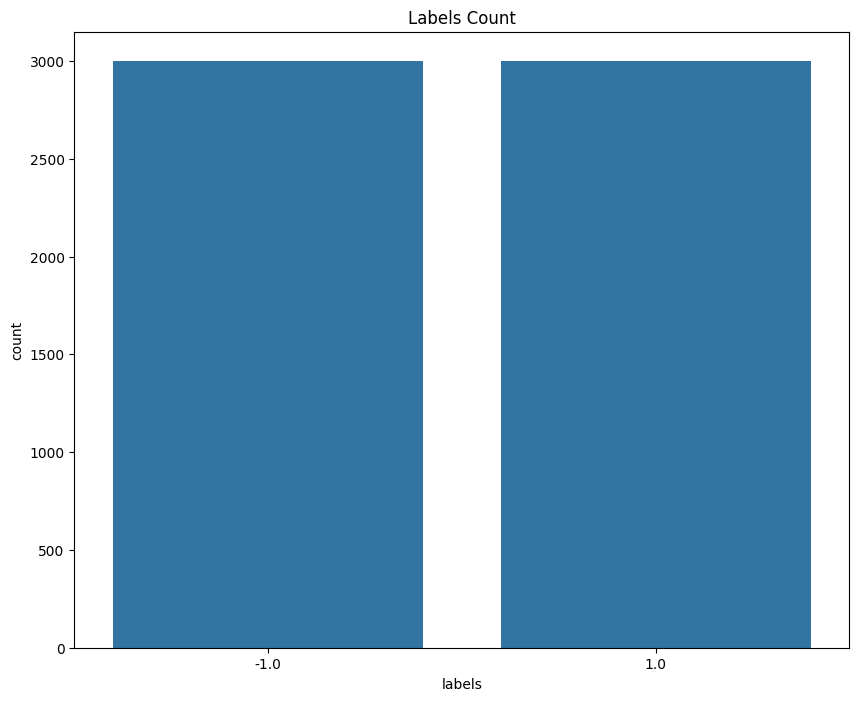

In [9]:
ax=plt.subplots(1,1,figsize=(10,8))
sns.countplot(data=X, x="labels")
plt.title("Labels Count")
plt.show()

Como ya vimos anteriomente nuestro conjunto de datos de entrenamiento tiene 6000 ejemplos, y teniendo en cuenta el gráfico anterior, nuestro conjunto de datos se encuentra balanceado debido a que cada clase tiene, según el gráfico, 3000 ejemplos.

## Feature Engineering
En primer lugar separamos las variables predictoras de las variables a predecir

In [10]:
X_train = X.drop(['labels'], axis=1) # Separa las variables predictoras de las variable a predecir
y_train = X['labels']

Luego aplicamos el método de Principal Component Analysis (PCA) para poder realizar una reducción de la dimensionalidad evaluando que la varianza de los datos no varíe mucho, por lo que debe ser cercano a 1

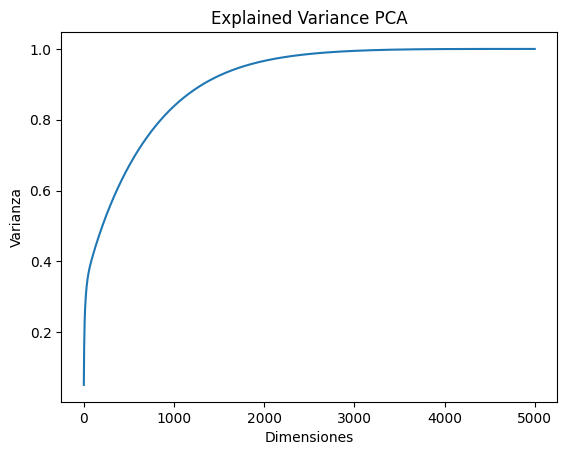

In [11]:
# Principal Component Analysis
pca = PCA()

X_train_PCA = pca.fit_transform(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)
plt.xlabel('Dimensiones')
plt.ylabel('Varianza')
plt.title("Explained Variance PCA")
plt.show()
train_index = range(0,len(X_train))
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

In [12]:
# Percentage of Variance Captured by 784 principal components
print("Variance Explained by all 784 principal components: ", \
      sum(pca.explained_variance_ratio_))

Variance Explained by all 784 principal components:  0.9999999999999994


In [13]:
# Percentage of Variance Captured by X principal components
importanceOfPrincipalComponents = \
    pd.DataFrame(data=pca.explained_variance_ratio_)
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T

print('Variance Captured by First 1000 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:999].sum(axis=1).values)
print('Variance Captured by First 1500 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:1499].sum(axis=1).values)
print('Variance Captured by First 2000 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:1999].sum(axis=1).values)
print('Variance Captured by First 2500 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:2499].sum(axis=1).values)
print('Variance Captured by First 3000 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:2999].sum(axis=1).values)
print('Variance Captured by First 3500 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:3499].sum(axis=1).values)

Variance Captured by First 1000 Principal Components:  [0.83827664]
Variance Captured by First 1500 Principal Components:  [0.92441109]
Variance Captured by First 2000 Principal Components:  [0.96620063]
Variance Captured by First 2500 Principal Components:  [0.98569556]
Variance Captured by First 3000 Principal Components:  [0.99453533]
Variance Captured by First 3500 Principal Components:  [0.99826127]


Como se puede observar las varianzas a partir de 3500 ya son muy cercanas a 1, por lo que podríamos reducir grandes cantidades de dimensiones.

En este caso, realizaremos una reducción de 2500 dimensiones o características ya que al eliminarlas podemos observar que la varianza sigue siendo cercana a 1, por lo que es una gran opción.

In [14]:
# Another option to delete features
# X_train = X_train_PCA[X_train_PCA.columns[:-2500]]
# X_train
pca = PCA(n_components=2500)
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)
X_train_PCA

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,10625.490378,2640.714856,6733.280600,8270.670175,1052.453861,-1268.286528,2136.147281,2995.585036,-2717.134945,3821.922620,...,47.300198,60.165378,-19.510625,-101.532315,-73.538388,-17.489034,21.543783,-87.558452,16.646820,-2.057938
1,5046.238859,-5301.992984,-4247.276014,-2492.178743,194.714529,453.653399,-571.140707,4750.232961,127.713598,1509.927317,...,-130.142492,22.335553,55.332455,-42.003360,-21.937086,100.123893,34.297055,23.479082,86.545993,-26.750262
2,1814.154499,-5894.792481,-2199.482361,2353.499823,3805.579323,-1156.720641,748.739064,-1887.485214,1264.444842,2083.392791,...,10.410932,-24.737367,-118.535186,3.777333,-115.616638,23.238325,-32.711228,-96.069291,24.945584,49.617786
3,4029.656430,-698.929215,95.233834,-2731.711253,2911.977481,-4642.479910,-1369.477445,2814.959907,-1506.103560,-296.072679,...,68.374875,65.388829,18.393603,180.287359,-76.961612,-38.839634,-116.105223,-73.178586,-20.735711,-86.357934
4,-5245.527368,475.361630,815.049564,-144.896441,-1065.833262,716.204011,-710.111986,-1606.667073,-1134.278057,-900.596161,...,41.644933,1.057538,52.241850,-91.130813,91.261870,-59.618080,-46.005100,11.344777,-99.728285,2.406763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,-2232.530331,2903.425664,-2139.586195,-1989.168746,1036.238436,-906.768239,609.273121,-858.406282,233.767713,2601.705092,...,-64.160085,-46.233350,51.069026,-169.674320,-48.175323,-13.231174,-115.612384,83.667991,-112.462560,-155.583651
5996,-3210.592532,1263.522049,149.225021,4161.845139,-780.867347,650.869990,-3466.330484,335.227646,-282.304989,-2333.403824,...,45.281169,-70.257431,-113.119740,45.995459,50.583835,10.574072,-75.404934,-17.554546,-104.781514,-63.788751
5997,875.082297,-5584.875465,-2768.445532,-1023.469035,-512.926243,2012.906319,-3582.173132,3099.537879,201.573706,110.640599,...,24.800881,-103.686147,-70.360371,69.639807,41.707012,-175.522092,-93.877293,-16.327444,122.951810,-20.807084
5998,-1065.712792,-4327.673850,2537.088454,-938.046345,-330.796766,-612.323790,-1430.262026,-693.794464,1026.712826,-131.405789,...,-75.123138,-54.385223,165.126932,-56.085382,-39.712057,160.263811,-28.881818,-41.995192,-91.259540,4.395140


Ya eliminadas las dimensiones de nuestro dataset de entrenamiento, tenemos que transformar igualmente los datos que utilizaremos para testear el modelo, por lo que utilizaremos los mismos egenvectores creados anteriormente en nuestro PCA para convertir nuestros datos

In [15]:
validation_data = gisette_data['validation']['data']
y_validation = gisette_data['validation']['labels']

X_validation = pd.DataFrame(data=validation_data, columns=['feature_'+str(i) for i in range(len(validation_data[0]))])
X_validation_PCA = pca.transform(X_validation)
validation_index = range(0,len(X_validation))
X_validation_PCA = pd.DataFrame(data=X_validation_PCA, index=validation_index)
X_validation_PCA

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,-803.888690,-3037.055967,-3523.337816,-749.396375,2514.678447,711.547801,677.346349,-1453.532295,3443.612862,-1271.466222,...,166.686657,19.152317,-234.816676,-60.869322,9.265326,203.154088,-179.379751,249.407584,-54.985779,-164.844412
1,-3792.161778,1733.063694,1863.417378,3315.044262,320.421031,6299.942971,-425.161966,-1926.443426,888.168743,544.846398,...,-170.581338,79.477956,28.576387,155.637366,-132.823592,128.755218,87.122617,-181.444092,-8.592071,35.865234
2,-2094.614492,4248.354006,-4356.378938,-1866.296383,3433.079856,227.263773,2633.290316,-319.199298,444.948828,538.111454,...,194.425574,-56.636965,283.013375,-21.150284,0.959490,173.293403,37.539787,59.587385,185.664003,30.428612
3,-2959.662707,-1297.261396,-364.368436,2079.135031,-1390.801318,-3738.134639,-1625.804610,1721.081058,-3496.279560,1390.072397,...,-52.784131,-22.043136,-87.577858,105.708248,-154.862766,69.300266,-7.830925,151.120769,87.282378,173.885058
4,-4183.689977,-2822.237482,-203.459795,1010.009601,-614.553813,-3413.042264,-232.506897,1366.180554,-548.925615,-435.283611,...,-30.832497,-132.965711,-323.984017,105.509448,-20.135289,-24.480450,-157.240446,-124.900771,-20.189803,-76.407232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1701.653682,-1496.392050,-4706.788349,-2587.262066,-1185.458548,1424.773715,1223.014999,-1410.624274,-1311.138773,-2635.645293,...,-46.791301,-92.201848,316.972888,427.429897,-85.322165,-155.724595,-36.344239,28.843193,11.033162,107.872337
996,3246.894530,-798.948861,5298.153452,-324.153008,6074.735915,4022.526997,5269.206357,-5067.112590,-929.870582,-16.671301,...,-77.807261,-10.954463,-158.059325,-22.881002,40.802886,301.818598,-263.958999,161.526907,39.539552,98.160884
997,-205.806891,5363.290338,5143.201032,667.650743,-3713.705459,1442.718870,5000.201648,-2393.327830,653.529140,277.730351,...,236.951498,-49.680981,-68.225794,107.668406,113.419235,10.006407,-180.790502,-146.800783,-207.479030,-135.580359
998,-177.125146,-3771.959878,-1333.895517,-2414.677511,-3758.326116,1461.779098,-1652.138342,1765.732570,-385.419763,575.854876,...,209.767890,-150.372146,114.047452,164.615374,25.430360,137.557183,193.375656,123.637195,-210.164041,-5.549706


### Prueba de feature selection
**Filter method:** Luego de llevar a cabo el método de PCA para reducir dimensionalidad realizaremos un método de selección de características y en este caso en particular será el método de filtro de correlación, por medio del cual eliminaremos las variables que menos correlación tengan con la variable a predecir usando correlación de Spearman

In [16]:
fs = pd.DataFrame(X_train_PCA)
fs['target'] = y_train
corr_matrix = fs.corr(method='spearman')
corr_matrix = corr_matrix.abs().unstack()
corr_target = corr_matrix['target'].sort_values(ascending=False) 
corr_target

target    1.000000
3         0.535174
0         0.463150
6         0.318902
2         0.197682
            ...   
1765      0.000015
701       0.000015
2296      0.000008
563       0.000007
1298      0.000002
Length: 2501, dtype: float64

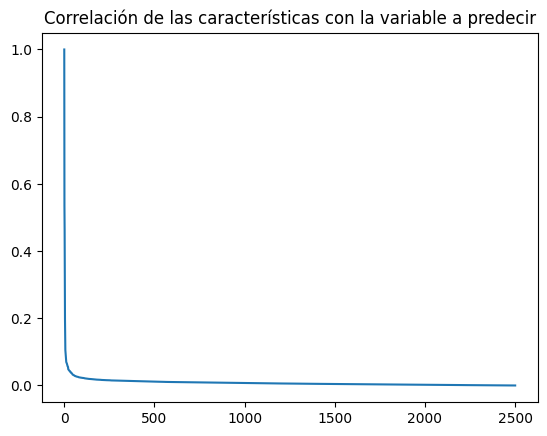

In [41]:
plt.plot(corr_target.values)
plt.title("Correlación de las características con la variable a predecir")
plt.show()

Como se puede observar, existen aproximadamente 2000 características que no tienen mucha correlación con respecto a la variable a predecir, por lo tanto, seleccionaremos un umbral de 0.056 para seleccionar nuestras características.

In [69]:
features_selected = corr_target[corr_target > 0.056]
features_selected

target    1.000000
3         0.535174
0         0.463150
6         0.318902
2         0.197682
5         0.140689
41        0.105567
24        0.098002
11        0.091735
13        0.081837
19        0.071585
10        0.069888
16        0.067694
35        0.066867
4         0.066144
1         0.063935
15        0.061133
46        0.058529
18        0.058056
43        0.056159
dtype: float64

Como se puede observar, claramente seleccionando 19 características tendríamos suficiente para entrenar los modelos con gran precisión, por lo cual seleccionaremos las 19 características anteriormente vistas tanto en los datos de entrenamiento como en los datos de prueba

In [71]:
X_train_fs = X_train_PCA[features_selected.index.drop("target")]
X_test_fs = X_validation_PCA[features_selected.index.drop("target")]
X_train_fs

,3,0,6,2,5,41,24,11,13,19,10,16,35,4,1,15,46,18,43
0,8270.670175,10625.490378,2136.147281,6733.280600,-1268.286528,-588.915273,-1406.301230,1313.350402,1146.643281,387.494460,1461.061080,-2281.306810,311.948204,1052.453861,2640.714856,-1865.469280,-774.005886,-230.614451,-236.412142
1,-2492.178743,5046.238859,-571.140707,-4247.276014,453.653399,1057.942032,-1489.220502,1054.749914,1017.496281,1186.080158,-2415.996819,-95.257757,455.754634,194.714529,-5301.992984,-105.218385,701.692763,-2069.004027,227.315448
2,2353.499823,1814.154499,748.739064,-2199.482361,-1156.720641,-199.411853,-1186.023920,-1008.621964,1384.901581,1612.143898,1823.112377,-470.976894,-1237.189430,3805.579323,-5894.792481,-2031.469975,-970.279328,524.281102,186.807360
3,-2731.711253,4029.656430,-1369.477445,95.233834,-4642.479910,-230.578247,-199.918400,4209.479324,-770.218087,923.424031,3464.529759,-1844.195166,-1364.876022,2911.977481,-698.929215,-2369.553082,516.534015,2007.711872,-846.553956
4,-144.896441,-5245.527368,-710.111986,815.049564,716.204011,495.439770,-703.698297,-1643.948054,2166.517129,99.118034,-385.936985,692.607935,186.024287,-1065.833262,475.361630,957.047040,-716.887217,-1130.508592,-182.458268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,-1989.168746,-2232.530331,609.273121,-2139.586195,-906.768239,-247.072925,-660.517713,-3368.104604,2185.611001,-101.898282,-462.088789,2404.719345,400.460515,1036.238436,2903.425664,-154.953727,-137.104543,498.020592,-1076.878087
5996,4161.845139,-3210.592532,-3466.330484,149.225021,650.869990,-27.348385,233.308086,606.438931,2735.453881,-1015.082343,90.113010,-930.071639,-126.511201,-780.867347,1263.522049,-62.226767,167.866246,1251.566916,-821.568350
5997,-1023.469035,875.082297,-3582.173132,-2768.445532,2012.906319,-281.351246,-1028.998877,253.844120,-804.560354,1105.647616,-63.034722,-612.661365,-689.977314,-512.926243,-5584.875465,147.827879,-225.508333,168.818511,907.779047
5998,-938.046345,-1065.712792,-1430.262026,2537.088454,-612.323790,1633.519055,604.036904,-1005.522910,-2375.195507,173.578303,-1708.391960,-818.627963,198.830443,-330.796766,-4327.673850,1720.879632,-96.743517,-1263.504731,50.160664


Luego de esto podremos entrenar los métodos para comparar entre hacer o no hacer selección de características y observar su efectividad.

## Pruebas de eficacia
Para probar la eficiencia de la selección de características y con ánimos de observar si nuestro modelo no queda sobre ajustado a los datos de entrenamiento, entrenaremos dos modelos, uno con las 20 características después de aplicar selección de características y otro con las 2500 características luego de aplicar reducción de dimensionalidad.

Todos los modelos tendrán los parámetros por defecto para tener igualdad de condiciones.

**Arbol de decisiones**

In [72]:
clf_PCA = tree.DecisionTreeClassifier(criterion='entropy', splitter='best')
clf_fs = tree.DecisionTreeClassifier(criterion='entropy', splitter='best')
clf_PCA = clf_PCA.fit(X_train_PCA,y_train)
clf_fs = clf_fs.fit(X_train_fs,y_train)

#Evaluación en el conjunto de prueba
y_pred_PCA = clf_PCA.predict(X_validation_PCA)
y_pred_fs = clf_fs.predict(X_test_fs)
print('=========================== ACCURACY WITH PCA ===========================')
print('Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: {:.2f}'.format(clf_PCA.score(X_train_PCA, y_train)))
print('Accuracy de RandomForestClassifier sobre el conjunto de prueba es: {:.2f}'.format(clf_PCA.score(X_validation_PCA, y_validation))) 
print('=========================== ACCURACY WITH FS ===========================')
print('Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: {:.2f}'.format(clf_fs.score(X_train_fs, y_train)))
print('Accuracy de RandomForestClassifier sobre el conjunto de prueba es: {:.2f}'.format(clf_fs.score(X_test_fs, y_validation))) 

=========================== ACCURACY WITH PCA ===========================
Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: 1.00
Accuracy de RandomForestClassifier sobre el conjunto de prueba es: 0.86
=========================== ACCURACY WITH FS ===========================
Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: 1.00
Accuracy de RandomForestClassifier sobre el conjunto de prueba es: 0.90


**Random Forest**

In [21]:
rf_PCA = ensemble.RandomForestClassifier(criterion='entropy')
rf_fs = ensemble.RandomForestClassifier(criterion='entropy')
rf_PCA = rf_PCA.fit(X_train_PCA,y_train)
rf_fs = rf_fs.fit(X_train_fs,y_train)

y_pred_PCA = rf_PCA.predict(X_validation_PCA)
y_pred_fs = rf_fs.predict(X_test_fs)
print('=========================== ACCURACY WITH PCA ===========================')
print('Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: {:.2f}'.format(rf_PCA.score(X_train_PCA, y_train)))
print('Accuracy de RandomForestClassifier sobre el conjunto de prueba es: {:.2f}'.format(rf_PCA.score(X_validation_PCA, y_validation))) 
print('=========================== ACCURACY WITH FS ===========================')
print('Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: {:.2f}'.format(rf_fs.score(X_train_fs, y_train)))
print('Accuracy de RandomForestClassifier sobre el conjunto de prueba es: {:.2f}'.format(rf_fs.score(X_test_fs, y_validation))) 

=========================== ACCURACY WITH PCA ===========================
Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: 1.00
Accuracy de RandomForestClassifier sobre el conjunto de prueba es: 0.88
=========================== ACCURACY WITH FS ===========================
Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: 1.00
Accuracy de RandomForestClassifier sobre el conjunto de prueba es: 0.96


**Redes neuronales**

In [24]:
mlp_PCA = neural_network.MLPClassifier(hidden_layer_sizes=(100,100,100,100,100,100))
mlp_fs = neural_network.MLPClassifier(hidden_layer_sizes=(100,100,100,100,100,100))
mlp_PCA = mlp_PCA.fit(X_train_PCA,y_train)
mlp_fs = mlp_fs.fit(X_train_fs,y_train)

y_pred_PCA = mlp_PCA.predict(X_validation_PCA)
y_pred_fs = mlp_fs.predict(X_test_fs)
print('=========================== ACCURACY WITH PCA ===========================')
print('Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: {:.2f}'.format(mlp_PCA.score(X_train_PCA, y_train)))
print('Accuracy de RandomForestClassifier sobre el conjunto de prueba es: {:.2f}'.format(mlp_PCA.score(X_validation_PCA, y_validation))) 
print('=========================== ACCURACY WITH FS ===========================')
print('Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: {:.2f}'.format(mlp_fs.score(X_train_fs, y_train)))
print('Accuracy de RandomForestClassifier sobre el conjunto de prueba es: {:.2f}'.format(mlp_fs.score(X_test_fs, y_validation))) 

=========================== ACCURACY WITH PCA ===========================
Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: 1.00
Accuracy de RandomForestClassifier sobre el conjunto de prueba es: 0.92
=========================== ACCURACY WITH FS ===========================
Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: 1.00
Accuracy de RandomForestClassifier sobre el conjunto de prueba es: 0.95


**Comparación en los 3 métodos**: A continuación se hace una comparación de los 3 métodos según el accuracy que recibió la predicción con el conjunto de prueba de cada modelo.

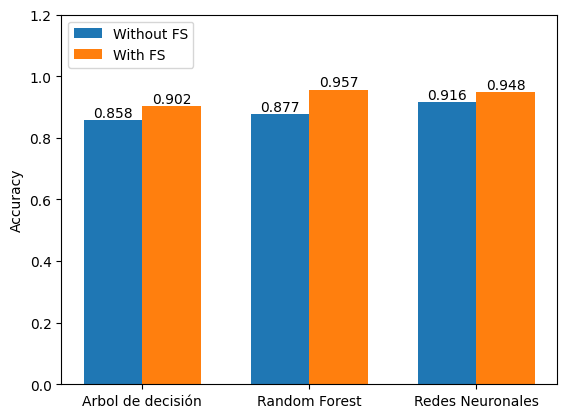

In [31]:
clf_score_PCA = clf_PCA.score(X_validation_PCA, y_validation)
clf_score_fs = clf_fs.score(X_test_fs, y_validation)
rf_score_PCA = rf_PCA.score(X_validation_PCA, y_validation)
rf_score_fs = rf_fs.score(X_test_fs, y_validation)
mlp_score_PCA = mlp_PCA.score(X_validation_PCA, y_validation)
mlp_score_fs = mlp_fs.score(X_test_fs, y_validation)

fig, ax = plt.subplots()
rects1=ax.bar(np.arange(3)-0.35/2,[clf_score_PCA,rf_score_PCA,mlp_score_PCA],0.35,label="Without FS")
rects2=ax.bar(np.arange(3)+0.35/2,[clf_score_fs,rf_score_fs,mlp_score_fs],0.35,label="With FS")

for rect in rects1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.3f' % height, ha='center', va='bottom')

for rect in rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.3f' % height, ha='center', va='bottom')

ax.set_ylabel('Accuracy')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(["Arbol de decisión","Random Forest","Redes Neuronales"])
ax.legend(loc='upper left')
ax.set_ylim(0, 1.2)

plt.show()

Como se puede observar utilizando los modelos de Machine Learning el accuracy mejora cuando se realiza una selección de características obteniendo al final 20 características.

In [ ]:
cmatrix2 = confusion_matrix(y_validation, y_pred2)
print("==============================================================")
print("Matriz de confusión:\n", cmatrix2)
print("==============================================================")
print("Reporte de clasificación: ")
print(classification_report(y_validation, y_pred2))